**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [12]:
import sys
IMAGES_FOLDER = 'ann'
sys.path.append('../util')

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [13]:
from packaging import version
import sklearn
import os

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [14]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [15]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ann` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [16]:
from ageron_homl3 import save_fig, get_model_root, get_image_root

# From Biological to Artificial Neurons
## The Perceptron

In [17]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers

In [18]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [19]:
# extra code – shows how to build and train a Perceptron

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

Saving figure perceptron_iris_plot


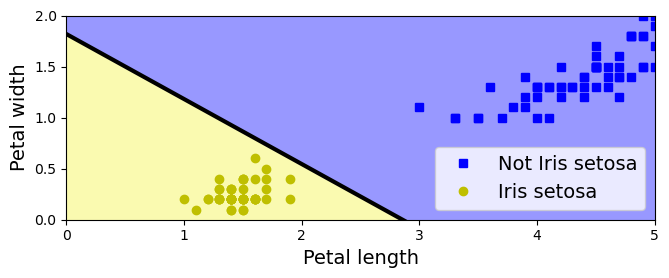

In [20]:
# extra code – plots the decision boundary of a Perceptron on the iris dataset

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)

save_fig("perceptron_iris_plot", images_folder=IMAGES_FOLDER)
plt.show()

**Activation functions**

Saving figure activation_functions_plot


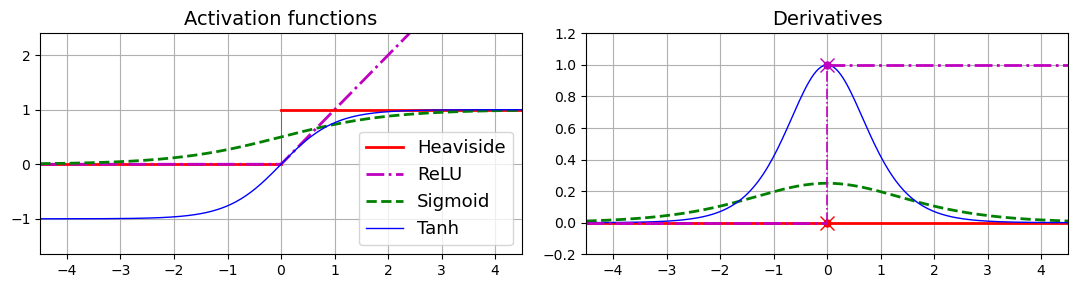

In [21]:
# extra code – this cell generates and saves Figure 10–8

from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot", images_folder=IMAGES_FOLDER)
plt.show()

## Regression MLPs

In [22]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

In [23]:
rmse

0.5053326657968771

## Classification MLPs

In [24]:
# extra code – this was left as an exercise for the reader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementing MLPs with Keras
## Building an Image Classifier Using the Sequential API
### Using Keras to load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `tf.keras.datasets`. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [25]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [26]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [27]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [28]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

Saving figure fashion_mnist_sample_plot


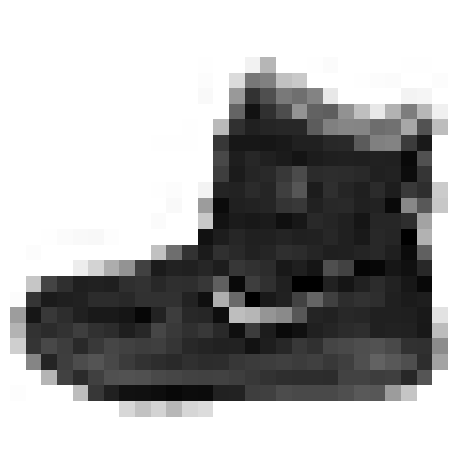

In [29]:
# extra code

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
save_fig("fashion_mnist_sample_plot", images_folder=IMAGES_FOLDER)
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [30]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [31]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is an ankle boot:

In [32]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


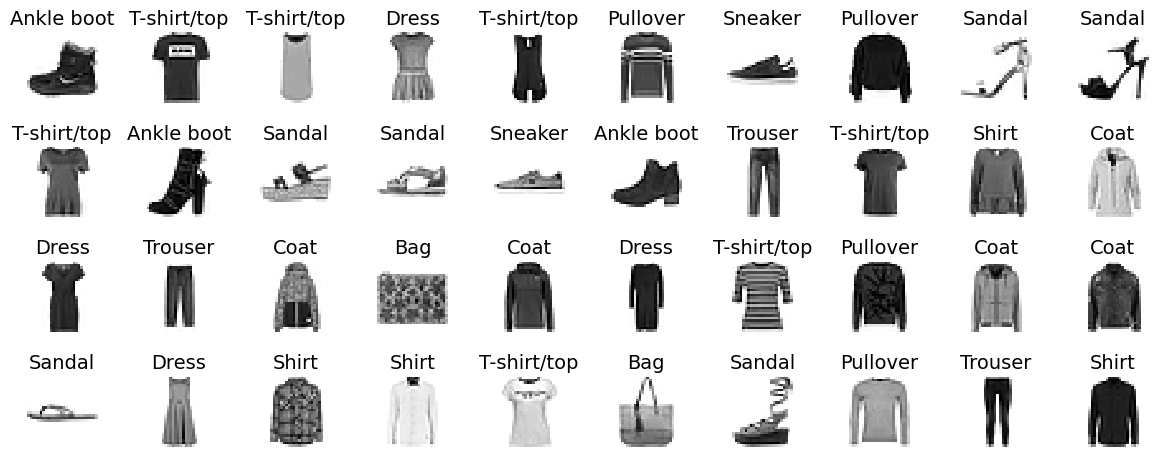

In [33]:
# extra code – this cell generates and saves Figure 10–10

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot", images_folder=IMAGES_FOLDER)
plt.show()

### Creating the model using the Sequential API

In [34]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

2025-01-24 15:54:33.963437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10527 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2025-01-24 15:54:33.964564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10527 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1
2025-01-24 15:54:33.965469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 10527 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1
2025-01-24 15:54:33.966429: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 10527 MB memory:  -> device: 3, name: NVIDIA GeForce

In [35]:
# extra code – clear the session to reset the name counters
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


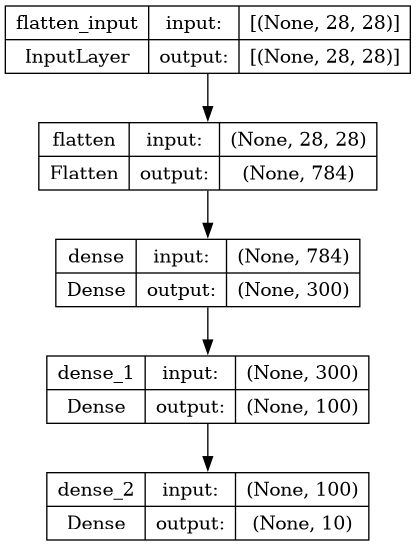

In [37]:
# extra code – another way to display the model's architecture
fashion_model_img=os.path.join(get_image_root(),IMAGES_FOLDER,"my_fashion_mnist_model.png")
tf.keras.utils.plot_model(model, fashion_model_img, show_shapes=True)

In [38]:
model.layers

In [39]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [40]:
model.get_layer('dense') is hidden1

True

In [41]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.02325504,  0.00806621,  0.05583832, ..., -0.05556929,
         0.03441587,  0.03886279],
       [-0.04083461, -0.00629422, -0.05278918, ...,  0.01730476,
         0.01591332, -0.05729256],
       [-0.0464266 ,  0.02890816, -0.03095332, ..., -0.00429845,
         0.06459762, -0.03644063],
       ...,
       [-0.03904134,  0.02672029, -0.06939004, ...,  0.0213225 ,
         0.05691104, -0.0228578 ],
       [ 0.02227834, -0.00532712,  0.0113752 , ..., -0.02986313,
        -0.00394529,  0.03063512],
       [-0.0108354 ,  0.01696613,  0.06218837, ...,  0.04752177,
        -0.06055224,  0.07270439]], dtype=float32)

In [42]:
weights.shape

(784, 300)

In [43]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [44]:
biases.shape

(300,)

### Compiling the model

In [45]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

In [46]:
# extra code – this cell is equivalent to the previous cell
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [47]:
# extra code – shows how to convert class ids to one-hot vectors
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Note: it's important to set `num_classes` when the number of classes is greater than the maximum class id in the sample.

In [48]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0])

### Training and evaluating the model

In [49]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30


2025-01-24 15:54:59.628767: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc8240251c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-24 15:54:59.628815: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-01-24 15:54:59.628824: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-01-24 15:54:59.628830: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-01-24 15:54:59.628836: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-01-24 15:54:59.628843: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (4): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-01-24 15:54:

1719/1719 [==============================] - 9s 4ms/step - loss: 0.7100 - sparse_categorical_accuracy: 0.7655 - val_loss: 0.5010 - val_sparse_categorical_accuracy: 0.8296
Epoch 2/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4847 - sparse_categorical_accuracy: 0.8330 - val_loss: 0.4657 - val_sparse_categorical_accuracy: 0.8338
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4388 - sparse_categorical_accuracy: 0.8468 - val_loss: 0.4244 - val_sparse_categorical_accuracy: 0.8526
Epoch 4/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4155 - sparse_categorical_accuracy: 0.8554 - val_loss: 0.3988 - val_sparse_categorical_accuracy: 0.8638
Epoch 5/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3955 - sparse_categorical_accuracy: 0.8610 - val_loss: 0.3903 - val_sparse_categorical_accuracy: 0.8610
Epoch 6/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3797 - sparse_categoric

In [51]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [52]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


Saving figure keras_learning_curves_plot


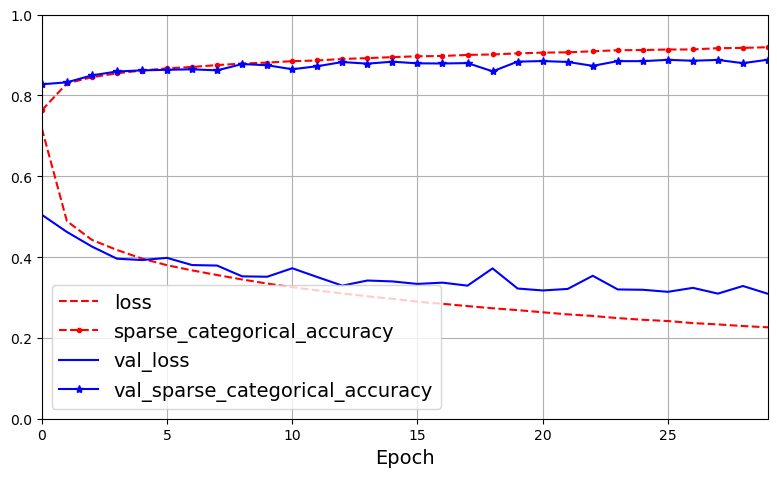

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
save_fig("keras_learning_curves_plot", images_folder=IMAGES_FOLDER)  # extra code
plt.show()

Saving figure keras_learning_curves_plot_shifted


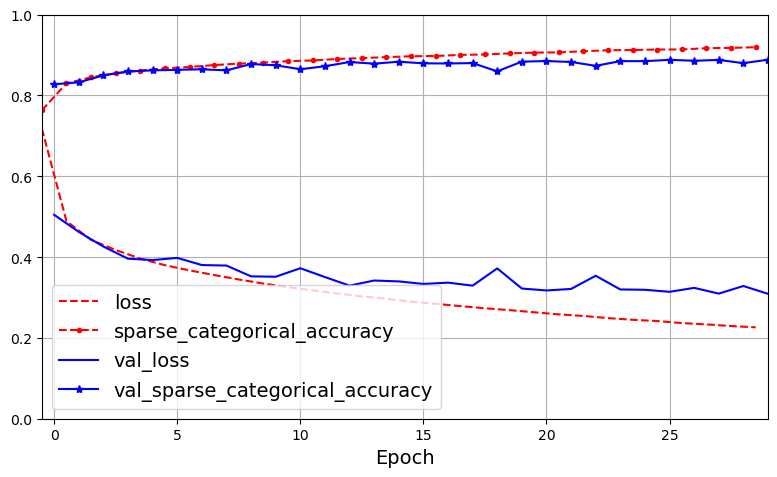

In [54]:
# extra code – shows how to shift the training curve by -1/2 epoch
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
save_fig("keras_learning_curves_plot_shifted", images_folder=IMAGES_FOLDER)
plt.show()

In [55]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3249 - sparse_categorical_accuracy: 0.8818


[0.3248889148235321, 0.8817999958992004]

### Using the model to make predictions

In [56]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 124ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [57]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [58]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [59]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


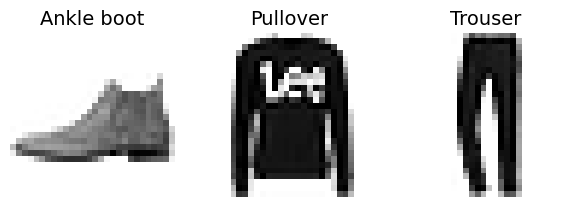

In [60]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False, images_folder=IMAGES_FOLDER)
plt.show()

## Building a Regression MLP Using the Sequential API

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [61]:
# extra code – load and split the California housing dataset, like earlier
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [62]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9254 - root_mean_squared_error: 0.9620 - val_loss: 0.5164 - val_root_mean_squared_error: 0.7186
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3878 - root_mean_squared_error: 0.6227 - val_loss: 2.1846 - val_root_mean_squared_error: 1.4780
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3816 - root_mean_squared_error: 0.6177 - val_loss: 0.3477 - val_root_mean_squared_error: 0.5897
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3482 - root_mean_squared_error: 0.5901 - val_loss: 0.5508 - val_root_mean_squared_error: 0.7421
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3355 - root_mean_squared_error: 0.5792 - val_loss: 0.3254 - val_root_mean_squared_error: 0.5704
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3252 - root_mean_squared_error: 0.5703 - val_loss: 0.3241 - val_

In [63]:
rmse_test

0.5323975086212158

In [64]:
y_pred

array([[0.47143698],
       [1.2719163 ],
       [5.231321  ]], dtype=float32)

## Building Complex Models Using the Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [65]:
# extra code – reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [66]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [67]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 normalization (Normalizati  (None, 8)                    17        ['input_1[0][0]']             
 on)                                                                                              
                                                                                                  
 dense (Dense)               (None, 30)                   270       ['normalization[0][0]']       
                                                                                                  
 dense_1 (Dense)             (None, 30)                   930       ['dense[0][0]']           

In [68]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9873 - root_mean_squared_error: 0.9936 - val_loss: 0.8225 - val_root_mean_squared_error: 0.9069
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4629 - root_mean_squared_error: 0.6804 - val_loss: 1.0431 - val_root_mean_squared_error: 1.0213
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4006 - root_mean_squared_error: 0.6329 - val_loss: 0.4270 - val_root_mean_squared_error: 0.6535
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3687 - root_mean_squared_error: 0.6072 - val_loss: 0.3933 - val_root_mean_squared_error: 0.6271
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3607 - root_mean_squared_error: 0.6006 - val_loss: 1.6207 - val_root_mean_squared_error: 1.2731
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3580 - root_mean_squared_error: 0.5983 - val_loss: 2.8887 - val_

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [69]:
tf.random.set_seed(42)  # extra code

In [70]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [71]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.5239 - root_mean_squared_error: 1.2345 - val_loss: 1.0119 - val_root_mean_squared_error: 1.0059
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5280 - root_mean_squared_error: 0.7266 - val_loss: 0.6280 - val_root_mean_squared_error: 0.7924
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4508 - root_mean_squared_error: 0.6714 - val_loss: 0.5107 - val_root_mean_squared_error: 0.7146
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4183 - root_mean_squared_error: 0.6468 - val_loss: 0.3804 - val_root_mean_squared_error: 0.6168
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3982 - root_mean_squared_error: 0.6310 - val_loss: 0.9620 - val_root_mean_squared_error: 0.9808
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3876 - root_mean_squared_error: 0.6226 - val_loss: 1.9395 - val_

Adding an auxiliary output for regularization:

In [72]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [73]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

**Warning**: in recent versions, Keras requires one metric per output, so I replaced `metrics=["RootMeanSquaredError"]` with `metrics=["RootMeanSquaredError", "RootMeanSquaredError"]` in the code below.

In [74]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
#               metrics=["RootMeanSquaredError", "RootMeanSquaredError"])
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics= "RootMeanSquaredError")

In [75]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 [==============================] - 2s 2ms/step - loss: 1.6626 - dense_2_loss: 1.5693 - dense_3_loss: 2.5020 - dense_2_root_mean_squared_error: 1.2527 - dense_3_root_mean_squared_error: 1.5818 - val_loss: 2.8403 - val_dense_2_loss: 1.4786 - val_dense_3_loss: 15.0951 - val_dense_2_root_mean_squared_error: 1.2160 - val_dense_3_root_mean_squared_error: 3.8852
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5476 - dense_2_loss: 0.5126 - dense_3_loss: 0.8628 - dense_2_root_mean_squared_error: 0.7160 - dense_3_root_mean_squared_error: 0.9289 - val_loss: 1.6012 - val_dense_2_loss: 0.6846 - val_dense_3_loss: 9.8510 - val_dense_2_root_mean_squared_error: 0.8274 - val_dense_3_root_mean_squared_error: 3.1386
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4720 - dense_2_loss: 0.4483 - dense_3_loss: 0.6852 - dense_2_root_mean_squared_error: 0.6695 - dense_3_root_mean_squared_error: 0.8278 - val_loss: 1.1149 - val_dense_2_los

In [76]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
# weighted_sum_of_losses, main_loss, aux_loss = eval_results
weighted_sum_of_losses, main_loss, aux_loss, _, _ = eval_results

162/162 [==============================] - 0s 2ms/step - loss: 0.3311 - dense_2_loss: 0.3254 - dense_3_loss: 0.3824 - dense_2_root_mean_squared_error: 0.5704 - dense_3_root_mean_squared_error: 0.6184


In [77]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 125ms/step


In [78]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 [==============================] - 0s 29ms/step


## Using the Subclassing API to Build Dynamic Models

In [79]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

**Warning**: as explained above, Keras now requires one metric per output, so I replaced `metrics=["RootMeanSquaredError"]` with `metrics=["RootMeanSquaredError", "RootMeanSquaredError"]` in the code below.

In [80]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
#               metrics=["RootMeanSquaredError", "RootMeanSquaredError"])
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics= "RootMeanSquaredError")
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 [==============================] - 2s 3ms/step - loss: 1.6701 - output_1_loss: 1.6170 - output_2_loss: 2.1481 - output_1_root_mean_squared_error: 1.2716 - output_2_root_mean_squared_error: 1.4656 - val_loss: 1.3458 - val_output_1_loss: 0.7611 - val_output_2_loss: 6.6085 - val_output_1_root_mean_squared_error: 0.8724 - val_output_2_root_mean_squared_error: 2.5707
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6673 - output_1_loss: 0.6593 - output_2_loss: 0.7398 - output_1_root_mean_squared_error: 0.8119 - output_2_root_mean_squared_error: 0.8601 - val_loss: 1.9158 - val_output_1_loss: 1.5814 - val_output_2_loss: 4.9252 - val_output_1_root_mean_squared_error: 1.2575 - val_output_2_root_mean_squared_error: 2.2193
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5355 - output_1_loss: 0.5274 - output_2_loss: 0.6082 - output_1_root_mean_squared_error: 0.7262 - output_2_root_mean_squared_error: 0.7799 - val_loss: 0.708

## Saving and Restoring a Model

**Warning**: Keras now recommends using the `.keras` format to save models, and the `h5` format for weights. Therefore I have updated the code in this section to first show what you need to change if you still want to use TensorFlow's `SavedModel` format, and then how you can use the recommended formats.

In [81]:
# extra code – delete the directory, in case it already exists

import shutil

models_path = os.path.join(get_model_root(), "my_keras_model")
shutil.rmtree("my_keras_model", ignore_errors=True)

**Warning**: Keras's `model.save()` method no longer supports TensorFlow's `SavedModel` format. However, you can still export models to the `SavedModel` format using `model.export()` like this:

In [82]:
# model.export(models_path)
model.save(models_path)

INFO:tensorflow:Assets written to: /Users/Jie/Documents/Richard/Reference/Notes/notes_on_geron_hands_on_machine_learning/handson-ml3/analysis/models/my_keras_model/assets


INFO:tensorflow:Assets written to: /Users/Jie/Documents/Richard/Reference/Notes/notes_on_geron_hands_on_machine_learning/handson-ml3/analysis/models/my_keras_model/assets


In [83]:
# extra code – show the contents of the my_keras_model/ directory
from pathlib import Path
for path in sorted(Path(models_path).glob("**/*")):
    print(path)

/Users/Jie/Documents/Richard/Reference/Notes/notes_on_geron_hands_on_machine_learning/handson-ml3/analysis/models/my_keras_model/assets
/Users/Jie/Documents/Richard/Reference/Notes/notes_on_geron_hands_on_machine_learning/handson-ml3/analysis/models/my_keras_model/fingerprint.pb
/Users/Jie/Documents/Richard/Reference/Notes/notes_on_geron_hands_on_machine_learning/handson-ml3/analysis/models/my_keras_model/keras_metadata.pb
/Users/Jie/Documents/Richard/Reference/Notes/notes_on_geron_hands_on_machine_learning/handson-ml3/analysis/models/my_keras_model/saved_model.pb
/Users/Jie/Documents/Richard/Reference/Notes/notes_on_geron_hands_on_machine_learning/handson-ml3/analysis/models/my_keras_model/variables
/Users/Jie/Documents/Richard/Reference/Notes/notes_on_geron_hands_on_machine_learning/handson-ml3/analysis/models/my_keras_model/variables/variables.data-00000-of-00001
/Users/Jie/Documents/Richard/Reference/Notes/notes_on_geron_hands_on_machine_learning/handson-ml3/analysis/models/my_kera

**Warning**: In Keras 3, it is no longer possible to load a TensorFlow `SavedModel` as a Keras model. However, you can load a `SavedModel` as a `tf.keras.layers.TFSMLayer` layer, but be aware that this layer can only be used for inference: no training.

In [84]:
# tfsm_layer = tf.keras.layers.TFSMLayer(models_path)
# y_pred_main, y_pred_aux = tfsm_layer((X_new_wide, X_new_deep))
# load the saved model
tfsm_layer = tf.keras.models.load_model(models_path)
y_pred_main, y_pred_aux = tfsm_layer.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 278ms/step


**Warning**: Keras now requires the saved weights to have the `.weights.h5` extension. There are no longer saved using the `SavedModel` format.

In [86]:
weight_file = os.path.join(
    get_model_root(), "my_keras_model", "my_weights.weights.h5")
model.save_weights(weight_file)

In [87]:
model.load_weights(weight_file)

To save a model using the `.keras` format, simply use `model.save()`:

In [88]:
model_file = os.path.join(models_path, "my_model.keras")
model.save(model_file)

To load a `.keras` model, use the `tf.keras.models.load_model()` function. If the model uses any custom object, you must pass them to the function via the `custom_objects` argument:

In [89]:
loaded_model = tf.keras.models.load_model(model_file,
                                          custom_objects={
                                              "WideAndDeepModel": WideAndDeepModel}
                                          )

## Using Callbacks

In [92]:
checkpoint_path = os.path.join(models_path, "my_checkpoints")
shutil.rmtree(checkpoint_path, ignore_errors=True)  # extra code

**Warning**: as explained earlier, Keras now requires the checkpoint files to have a `.weights.h5` extension:

In [93]:
checkpoints_file = os.path.join(checkpoint_path, "my_checkpoints.weights.h5")
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoints_file,
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 0.3301 - output_1_loss: 0.3239 - output_2_loss: 0.3855 - output_1_root_mean_squared_error: 0.5691 - output_2_root_mean_squared_error: 0.6209 - val_loss: 0.4068 - val_output_1_loss: 0.3945 - val_output_2_loss: 0.5173 - val_output_1_root_mean_squared_error: 0.6281 - val_output_2_root_mean_squared_error: 0.7192
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.3308 - output_1_loss: 0.3247 - output_2_loss: 0.3851 - output_1_root_mean_squared_error: 0.5698 - output_2_root_mean_squared_error: 0.6206 - val_loss: 0.3385 - val_output_1_loss: 0.3318 - val_output_2_loss: 0.3982 - val_output_1_root_mean_squared_error: 0.5760 - val_output_2_root_mean_squared_error: 0.6310
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.3304 - output_1_loss: 0.3248 - output_2_loss: 0.3810 - output_1_root_mean_squared_error: 0.5699 - output_2_root_mean_squared_error: 0.6172 - val_loss: 0.621

In [94]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3208 - output_1_loss: 0.3150 - output_2_loss: 0.3727 - output_1_root_mean_squared_error: 0.5613 - output_2_root_mean_squared_error: 0.6105 - val_loss: 0.5509 - val_output_1_loss: 0.5501 - val_output_2_loss: 0.5581 - val_output_1_root_mean_squared_error: 0.7417 - val_output_2_root_mean_squared_error: 0.7471
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3223 - output_1_loss: 0.3166 - output_2_loss: 0.3730 - output_1_root_mean_squared_error: 0.5627 - output_2_root_mean_squared_error: 0.6107 - val_loss: 0.4086 - val_output_1_loss: 0.4122 - val_output_2_loss: 0.3769 - val_output_1_root_mean_squared_error: 0.6420 - val_output_2_root_mean_squared_error: 0.6139
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3222 - output_1_loss: 0.3169 - output_2_loss: 0.3695 - output_1_root_mean_squared_error: 0.5630 - output_2_root_mean_squared_error: 0.6079 - val_loss: 0.

In [95]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [96]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

Epoch=0, val/train=1.02
Epoch=1, val/train=1.08
Epoch=2, val/train=1.04
Epoch=3, val/train=1.01
Epoch=4, val/train=0.97
Epoch=5, val/train=1.26
Epoch=6, val/train=2.64
Epoch=7, val/train=4.09
Epoch=8, val/train=2.58
Epoch=9, val/train=1.61


## Using TensorBoard for Visualization

TensorBoard is preinstalled on Colab, but not the `tensorboard-plugin-profile`, so let's install it:

In [97]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

In [98]:
log_path = os.path.join(models_path, "my_logs")
shutil.rmtree(log_path, ignore_errors=True)

In [99]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir=log_path):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [100]:
# extra code – builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [101]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/20


2025-01-22 21:53:14.353075: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-01-22 21:53:14.353114: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-01-22 21:53:14.353173: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


191/363 [==============>...............] - ETA: 0s - loss: 2.4811 - root_mean_squared_error: 1.5751

2025-01-22 21:53:15.207204: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-01-22 21:53:15.207225: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-01-22 21:53:15.383243: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.


226/363 [=================>............] - ETA: 0s - loss: 2.3110 - root_mean_squared_error: 1.5202

2025-01-22 21:53:15.435125: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2025-01-22 21:53:15.448062: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: /Users/Jie/Documents/Richard/Reference/Notes/notes_on_geron_hands_on_machine_learning/handson-ml3/analysis/models/my_keras_model/my_logs/run_2025_01_22_21_51_27/plugins/profile/2025_01_22_21_53_15/Cortex.local.xplane.pb


363/363 [==============================] - 2s 3ms/step - loss: 1.7610 - root_mean_squared_error: 1.3270 - val_loss: 0.7817 - val_root_mean_squared_error: 0.8841
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7241 - root_mean_squared_error: 0.8510 - val_loss: 0.7087 - val_root_mean_squared_error: 0.8419
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6555 - root_mean_squared_error: 0.8097 - val_loss: 0.6258 - val_root_mean_squared_error: 0.7911
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6102 - root_mean_squared_error: 0.7812 - val_loss: 0.5643 - val_root_mean_squared_error: 0.7512
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5760 - root_mean_squared_error: 0.7589 - val_loss: 0.5287 - val_root_mean_squared_error: 0.7271
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5462 - root_mean_squared_error: 0.7391 - val_loss: 0.5032 - val_root_mean_s

In [102]:
print("my_logs")
for path in sorted(Path(log_path).glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
                          run_2025_01_22_21_51_27
                            plugins
                              profile
                                2025_01_22_21_53_15
                                  Cortex.local.xplane.pb
                            train
                              events.out.tfevents.1737604394.Cortex.local.46064.0.v2
                            validation
                              events.out.tfevents.1737604395.Cortex.local.46064.1.v2


Let's load the `tensorboard` Jupyter extension and start the TensorBoard server: 

In [104]:
%load_ext tensorboard
%tensorboard --logdir=../../models/my_keras_model/my_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

**Note**: if you prefer to access TensorBoard in a separate tab, click the "localhost:6006" link below:

In [105]:
# extra code

if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

You can use also visualize histograms, images, text, and even listen to audio using TensorBoard:

In [106]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

**Note**: it used to be possible to easily share your TensorBoard logs with the world by uploading them to https://tensorboard.dev/. Sadly, this service will shut down in December 2023, so I have removed the corresponding code examples from this notebook.

When you stop this Jupyter kernel (a.k.a. Runtime), it will automatically stop the TensorBoard server as well. Another way to stop the TensorBoard server is to kill it, if you are running on Linux or MacOSX. First, you need to find its process ID:

In [107]:
# extra code – lists all running TensorBoard server instances

from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./my_logs (started 0:03:59 ago; pid 9802)


Next you can use the following command on Linux or MacOSX, replacing `<pid>` with the pid listed above:

    !kill <pid>

On Windows:

    !taskkill /F /PID <pid>

# Fine-Tuning Neural Network Hyperparameters

In this section we'll use the Fashion MNIST dataset again:

In [108]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [109]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [110]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner~=1.4.6

In [111]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [113]:
fashion_path = os.path.join(get_model_root(), "my_fashion_mnist")
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory=fashion_path, project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 38s]
val_accuracy: 0.8324000239372253

Best val_accuracy So Far: 0.8623999953269958
Total elapsed time: 00h 03m 22s


In [114]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [115]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [116]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8623999953269958


In [117]:
best_trial.metrics.get_last_value("val_accuracy")

0.8623999953269958

In [118]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3261 - accuracy: 0.8781
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3185 - accuracy: 0.8806
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3091 - accuracy: 0.8851
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3016 - accuracy: 0.8878
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2962 - accuracy: 0.8888
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2882 - accuracy: 0.8914
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2816 - accuracy: 0.8953
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2765 - accuracy: 0.8966
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2722 - accuracy: 0.8981
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.3974 

In [119]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [120]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory=fashion_path, project_name="hyperband")

In [121]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 39s]
val_accuracy: 0.8141999840736389

Best val_accuracy So Far: 0.8784000277519226
Total elapsed time: 00h 20m 03s


In [122]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory=fashion_path, project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 47s]
val_accuracy: 0.8393999934196472

Best val_accuracy So Far: 0.8605999946594238
Total elapsed time: 00h 06m 40s


In [123]:
%tensorboard --logdir {root_logdir}

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2025-01-22 22:53:36.928007: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

# Exercise solutions

## 1. to 9.

1. Visit the [TensorFlow Playground](https://playground.tensorflow.org/) and play around with it, as described in this exercise.
2. Here is a neural network based on the original artificial neurons that computes _A_ ⊕ _B_ (where ⊕ represents the exclusive OR), using the fact that _A_ ⊕ _B_ = (_A_ ∧ ¬ _B_) ∨ (¬ _A_ ∧ _B_). There are other solutions—for example, using the fact that _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ ¬(_A_ ∧ _B_), or the fact that _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ (¬ _A_ ∨ ¬ _B_), and so on.<br /><img width="70%" src="images/ann/exercise2.png" />
3. A classical Perceptron will converge only if the dataset is linearly separable, and it won't be able to estimate class probabilities. In contrast, a Logistic Regression classifier will generally converge to a reasonably good solution even if the dataset is not linearly separable, and it will output class probabilities. If you change the Perceptron's activation function to the sigmoid activation function (or the softmax activation function if there are multiple neurons), and if you train it using Gradient Descent (or some other optimization algorithm minimizing the cost function, typically cross entropy), then it becomes equivalent to a Logistic Regression classifier.
4. The sigmoid activation function was a key ingredient in training the first MLPs because its derivative is always nonzero, so Gradient Descent can always roll down the slope. When the activation function is a step function, Gradient Descent cannot move, as there is no slope at all.
5. Popular activation functions include the step function, the sigmoid function, the hyperbolic tangent (tanh) function, and the Rectified Linear Unit (ReLU) function (see Figure 10-8). See Chapter 11 for other examples, such as ELU and variants of the ReLU function.
6. Considering the MLP described in the question, composed of one input layer with 10 passthrough neurons, followed by one hidden layer with 50 artificial neurons, and finally one output layer with 3 artificial neurons, where all artificial neurons use the ReLU activation function:
    * The shape of the input matrix **X** is _m_ × 10, where _m_ represents the training batch size.
    * The shape of the hidden layer's weight matrix **W**<sub>_h_</sub> is 10 × 50, and the length of its bias vector **b**<sub>_h_</sub> is 50.
    * The shape of the output layer's weight matrix **W**<sub>_o_</sub> is 50 × 3, and the length of its bias vector **b**<sub>_o_</sub> is 3.
    * The shape of the network's output matrix **Y** is _m_ × 3.
    * **Y** = ReLU(ReLU(**X** **W**<sub>_h_</sub> + **b**<sub>_h_</sub>) **W**<sub>_o_</sub> + **b**<sub>_o_</sub>). Recall that the ReLU function just sets every negative number in the matrix to zero. Also note that when you are adding a bias vector to a matrix, it is added to every single row in the matrix, which is called _broadcasting_.
7. To classify email into spam or ham, you just need one neuron in the output layer of a neural network—for example, indicating the probability that the email is spam. You would typically use the sigmoid activation function in the output layer when estimating a probability. If instead you want to tackle MNIST, you need 10 neurons in the output layer, and you must replace the sigmoid function with the softmax activation function, which can handle multiple classes, outputting one probability per class. If you want your neural network to predict housing prices like in Chapter 2, then you need one output neuron, using no activation function at all in the output layer. Note: when the values to predict can vary by many orders of magnitude, you may want to predict the logarithm of the target value rather than the target value directly. Simply computing the exponential of the neural network's output will give you the estimated value (since exp(log _v_) = _v_).
8. Backpropagation is a technique used to train artificial neural networks. It first computes the gradients of the cost function with regard to every model parameter (all the weights and biases), then it performs a Gradient Descent step using these gradients. This backpropagation step is typically performed thousands or millions of times, using many training batches, until the model parameters converge to values that (hopefully) minimize the cost function. To compute the gradients, backpropagation uses reverse-mode autodiff (although it wasn't called that when backpropagation was invented, and it has been reinvented several times). Reverse-mode autodiff performs a forward pass through a computation graph, computing every node's value for the current training batch, and then it performs a reverse pass, computing all the gradients at once (see Appendix B for more details). So what's the difference? Well, backpropagation refers to the whole process of training an artificial neural network using multiple backpropagation steps, each of which computes gradients and uses them to perform a Gradient Descent step. In contrast, reverse-mode autodiff is just a technique to compute gradients efficiently, and it happens to be used by backpropagation.
9. Here is a list of all the hyperparameters you can tweak in a basic MLP: the number of hidden layers, the number of neurons in each hidden layer, and the activation function used in each hidden layer and in the output layer. In general, the ReLU activation function (or one of its variants; see Chapter 11) is a good default for the hidden layers. For the output layer, in general you will want the sigmoid activation function for binary classification, the softmax activation function for multiclass classification, or no activation function for regression. If the MLP overfits the training data, you can try reducing the number of hidden layers and reducing the number of neurons per hidden layer.

## 10.

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `tf.keras.datasets.mnist.load_data()`. See if you can get over 98% accuracy by manually tuning the hyperparameters. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Next, try tuning the hyperparameters using Keras Tuner with all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

**TODO**: update this solution to use Keras Tuner.

Let's load the dataset:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [ ]:
X_train_full.shape

Each pixel intensity is also represented as a byte (0 to 255):

In [ ]:
X_train_full.dtype

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [ ]:
y_train

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [ ]:
X_valid.shape

In [ ]:
X_test.shape

Let's take a look at a sample of the images in the dataset:

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [ ]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [ ]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

We can now plot the loss as a functionof the learning rate:

In [ ]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
run_index = 1 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

In [ ]:
model = tf.keras.models.load_model("my_mnist_model.keras") # rollback to best model
model.evaluate(X_test, y_test)

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [ ]:
%tensorboard --logdir=./my_mnist_logs